In [4]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm, chi2, nbinom, logistic
from matplotlib import pyplot as plt
import scipy.linalg as la
import warnings
import autograd.numpy as anp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.stats import gaussian_kde
from tqdm import tqdm

In [7]:
class PoissonAnalysis:
    def __init__(self, true_beta=np.array([1, -4e-5]), generate_plots=True):
        self.true_beta = true_beta
        self.generate_data()

        pass

    def generate_data(self, n=10000):

        self.n = n
        b0 = self.true_beta[0]  # intercept
        b1 = self.true_beta[1]  # slope
        self.censor_threshold = 7

        # Generate predictor variable
        x = np.random.uniform(0, 2.5, n)

        # Calculate lambda (mean) for each observation
        lambda_i = np.exp(b0 + b1 * x)

        # Generate Poisson random variables
        y = np.random.poisson(lambda_i)

        # Calculate mean for each obseon based on a linear model
        #mu_i = b0 + b1 * x

        # Generate Normal random variables instead of Poisson
        #y = np.random.normal(mu_i)  # Using standard deviation of 1


        # Create censored version
        self.y_censored = np.where(y > self.censor_threshold, self.censor_threshold, y)
        censored = (y > self.censor_threshold).astype(int)

        # Create DataFrame
        self.data = pd.DataFrame({
            'x': x,
            'y': self.y_censored,
            'censored': censored
        })

        self.x = self.data["x"]
        self.y = self.data["y"]
        self.T = self.y.copy()
        self.T[self.data['censored'] == 0] = self.y + 1 #  If there is no censoring, all that matters is T > y
        self.x = self.x.to_numpy()
        self.y = self.y.to_numpy()
        self.T = self.T.to_numpy()

    def ell(self, b):
        xb = b[0] + b[1]*self.x

        lambda_ = anp.exp(xb)

        def summation(T):
            return anp.sum([(lambda_**k)/factorial(k) for k in range(int(T))])

        sum = anp.array([summation(int(Ti)) for Ti in self.T])
        censored_point = (self.y == self.T).astype(int)

        first_part = ((1-censored_point) * (self.y*anp.log(lambda_ + 1e-10) - lambda_ - anp.log(factorial(self.y))))
        second_part = censored_point * anp.log(1 - anp.exp(lambda_)*sum)
        Q = anp.where(anp.isnan(first_part), 0, first_part) +  anp.where(anp.isnan(second_part), 0, second_part)
        # nan's are filled with zeros, because it likely means that point isn't censored.

        out = -1*anp.mean(Q)
        if anp.isinf(out):
            out = 1e10
        return out

    def tobit_likelihood(self, b):

        xb = b[1] + b[2]*self.x
        alpha = (self.y - xb)  / b[0]

        # Generate mask
        censored_points = self.y == self.T
        uncensored_points = ~censored_points

        # Calculate censored and uncensored portions of the likelihood function
        uncensored_portion = np.log((1/b[0])*(norm.pdf(alpha[uncensored_points])))
        censored_portion = norm.logsf((alpha[censored_points]))

        # Handle nan values by outputting a very negative value
        uncensored_portion = np.nan_to_num(uncensored_portion, nan=-1e6)
        censored_portion = np.nan_to_num(censored_portion, nan=-1e6)

        Q = np.zeros_like(alpha)
        Q[censored_points] = censored_portion
        Q[uncensored_points] = uncensored_portion

        return -np.mean(Q)


    def solve_poisson(self, suppress_output=False):

        warnings.simplefilter('ignore')
        # Find solution using scipy's minimize tools
        sol = opt.minimize(self.ell, x0=np.array([0, 0]), method='BFGS', options={'disp': not suppress_output})
        if not suppress_output:
            print(sol)
        # Save the coefficient vector and variance matrix
        self.beta_poisson = sol.x
        self.V = sol.hess_inv # NOTE: Since the likelihood function is defined as negative, we don't need the negative sign to calculate V
        return self.beta_poisson, self.V


    def solve_tobit(self, suppress_output=False):
        warnings.simplefilter('ignore')
        bounds = ((0, 500),(-1, 1), (-1,1))

        # b0 is std_dev, b1 is beta0, b2 is beta1
        sol = opt.differential_evolution(self.tobit_likelihood, x0=np.array([100, 0.5, 0.5]), bounds=bounds)
        if not suppress_output:
            print(sol)
        self.beta_tobit = sol.x
        # In this case the marginal effect is just self.beta_tobit[2]
        return self.beta_tobit

    def E_Y(self, b, x): # The expected value of Y, given beta and x
        return np.exp(-1*(b[0] + b[1]*x))

    def d_E_Y(self, b,x): # The derivative of E_Y wrt x
        return -1*b[1] * np.exp(-1*(b[0] + b[1]*x))

    def find_marginal_effects(self, graph_results=True):
        self.me_poisson = self.d_E_Y(self.beta_poisson, self.x)
        self.me_tobit = np.ones_like(self.x) * self.beta_tobit[2]
        self.me_true = self.d_E_Y(self.true_beta, self.x)

        # Graph the results
        if graph_results:
            plt.title("Marginal Effects")
            plt.plot(self.x, self.me_poisson, 'b,', label="Poisson")
            plt.plot(self.x, self.me_tobit, 'r,', label="Tobit")
            plt.plot(self.x, self.me_true, 'g,', label="True effect")
            plt.xlabel("x")
            plt.ylabel(" $\partial \mathbb{E}[y]$ / $\partial x$")
            # Create proxy artists for the legend
            legend_handles = [
                plt.Line2D([], [], marker='o', color='blue', linestyle='', markersize=6, label='Poisson'),
                plt.Line2D([], [], marker='o', color='red', linestyle='', markersize=6, label='Tobit'),
                plt.Line2D([], [], marker='o', color='green', linestyle='', markersize=6, label='True Effect')
            ]
            # Add the legend using the proxy artists
            plt.legend(handles=legend_handles)

            plt.show()

        return self.me_poisson, self.me_tobit, self.me_true

    def Wald(self, R, b, r, alpha=0.05, suppress_output=True):
        W = self.n*((R@b - r).T @ la.inv(R@self.V@(R.T))@(R@b-r))
        p_value = 1 - chi2.cdf(x=W, df=np.linalg.matrix_rank(R))

        if not suppress_output:
            print(f"Wald statistic: {W}")
            print(f"P value: {p_value}")
            print(f"Alpha: {alpha}")

            if p_value < alpha:
                print("Significance found: H_0 rejected")
            else:
                print("Failed to reject")

        return W, p_value

  1%|          | 1/100 [00:00<00:50,  1.96it/s]

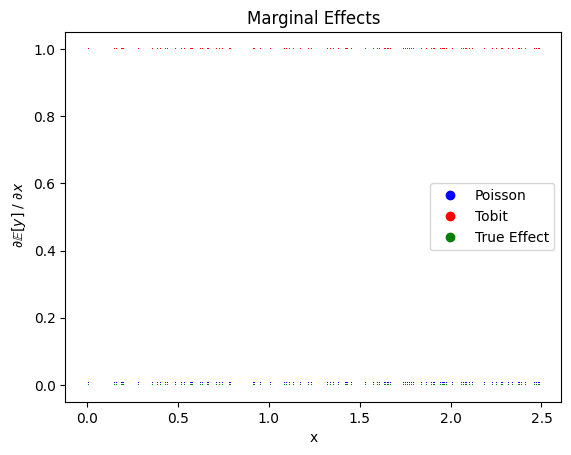

100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


In [8]:
# Test the object
n_list = 10 ** np.arange(1, 5)
true_betas = []
poisson_coeffs = []
standard_errors = []
tobit_coeffs = []
p_value = []
avg_me_poisson = np.zeros(100, dtype=np.float128)
avg_me_tobit = np.zeros(100, dtype=np.float128)
avg_me_truth = np.zeros(100, dtype=np.float128)
n = 100
analysis = PoissonAnalysis()
for i in tqdm(range(100)):
    graph_results = False
    if i == 1:
        graph_results = True

    analysis.generate_data(n=n)
    analysis.solve_poisson(suppress_output=True)
    analysis.solve_tobit(suppress_output=True)
    me_poisson, me_tobit, me_truth = analysis.find_marginal_effects(graph_results=graph_results)

    avg_me_poisson[i] = (np.mean(me_poisson))
    avg_me_tobit[i] = (np.mean(me_tobit))
    avg_me_truth[i] = (np.mean(me_truth))

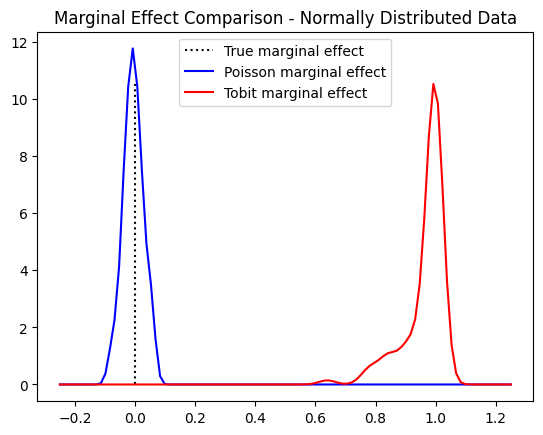

In [9]:
# Maybe graph the results
# Make a KDE with NegBin Coefficients
domain = np.linspace(-.25, 1.25, 100)
kde_poisson = gaussian_kde(avg_me_poisson).evaluate(domain)
kde_tobit = gaussian_kde(avg_me_tobit).evaluate(domain)
kde_truth = gaussian_kde(avg_me_truth).evaluate(domain)
plt.plot([avg_me_truth[0], avg_me_truth[0]], [0, np.max(kde_tobit)], 'k:', label="True marginal effect")
plt.plot(domain, kde_poisson, 'b-', label="Poisson marginal effect")
plt.plot(domain, kde_tobit, 'r-', label="Tobit marginal effect")
plt.title("Marginal Effect Comparison - Normally Distributed Data")
plt.legend(loc="upper center")
plt.show()